![DSME-logo](./images/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---

DQN Implementation

Orignal Paper: [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602)

# DSME Bonus Point Assignment II Part DQN

## Library Imports

In [2]:
import os
import copy
import time
import random
import warnings
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from tqdm import notebook
from easydict import EasyDict as edict
from IPython.display import Video, display

import utils.helper_fns as hf

import gym
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from stable_baselines3.common.buffers import ReplayBuffer

from typing import NamedTuple

warnings.filterwarnings("ignore", category=DeprecationWarning)

os.environ['SDL_VIDEODRIVER'] = 'dummy'
os.environ['WANDB_NOTEBOOK_NAME'] = 'dqn.ipynb'

plt.rcParams['figure.dpi'] = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

## Initializations

### Experiment

We primarily use dictionaries for initializing experiment parameters and training hyperparameters. We use the `EasyDict` (imported as `edict`) library, which allows us to access dict values as attributes while retaining the operations and properties of the original python `dict`! [[Github Link](https://github.com/makinacorpus/easydict)]

In this notebook we use a few `edicts` with `exp` being one of them. It is initialized in the following cell and has keys and values containing information about the experiment being run. Although initialized in this section, we keep adding new keys and values to the dict in the later sections as well.  

This notebook supports gym environments with observation space of type `gym.spaces.Box` and action space of type `gym.spaces.Discrete`. Eg: Acrobot-v1, CartPole-v1, MountainCar-v0

In [11]:
exp = edict()

exp.exp_name = 'DQN'  # algorithm name, in this case it should be 'DQN'
exp.env_id = 'CartPole-v1'  # name of the gym environment to be used in this experiment. Eg: Acrobot-v1, CartPole-v1, MountainCar-v0
exp.device = device.type  # save the device type used to load tensors and perform tensor operations

set_random_seed = True  # set random seed for reproducibility of python, numpy and torch
exp.seed = 2

# name of the project in Weights & Biases (wandb) to which logs are patched. (only if wandb logging is enabled)
# if the project does not exist in wandb, it will be created automatically
wandb_prj_name = f"RLLBC_{exp.env_id}"

# name prefix of output files generated by the notebook
exp.run_name = f"{exp.env_id}__{exp.exp_name}__{exp.seed}__{datetime.now().strftime('%y%m%d_%H%M%S')}"

if set_random_seed:
    random.seed(exp.seed)
    np.random.seed(exp.seed)
    torch.manual_seed(exp.seed)
    torch.backends.cudnn.deterministic = set_random_seed

### Agent Model Class

The `Agent` class consists of two neural networks with the exact same architecture: the *Q-network* and the *target network*. Both networks are taking a state as input and evaluate to *Q-values* for every possible (discrete) action. The class provides methods to query the networks, i.e. `get_q_values` and `get_target_values`.

Note that the target network will not be subject to the optimizer, meaning that only the Q-network will be modified by the optimizer through gradient steps. Instead, the target network is periodically synchronized with the Q-network by the means of the function `synchronize_networks`.

The `Agent` class also provides a method to retrieve the best action for a state according to the current Q-network, that is the action with the highest Q-value.

In [12]:
class Agent(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.q_network = nn.Sequential(
            nn.Linear(np.array(env.single_observation_space.shape).prod(), 16),
            nn.ReLU(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, env.single_action_space.n),
        )

        self.target_network = copy.deepcopy(self.q_network)

    def get_q_values(self, x):
        return self.q_network(x)

    def get_target_values(self, x):
        return self.target_network(x)

    def synchronize_networks(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def get_action(self, x, greedy=True):
        q_vals = self.get_q_values(x)
        action = q_vals.argmax(dim=1)
        return action

### Training Params & Agent Hyperparams
The second dictionary we use, `hypp`, is initialized in the following cell. It has keys and values containing the hyperparameters necessary to the algorithm.

The parameters and hyperparameters in this section are broadly categorized as below:
1. Flags for logging: 
    - They are stored in the `exp` dict. 
    - This notebook uses tensorboard logging by deafult to log experiment metrics. These tb log files are saved in the directory `logs/<exp.exp_type>/<exp.run_name>/tb`. (to learn about `exp.exp_type` refer point 3. below)
    - To enable logging of gym videos of the agent's interaction with the env set `exp.capture_video = True`
    - Patch tensorboard logs and gym videos to Weigths & Biases (wandb) by setting `exp.enable_wandb_logging = True`
2. Flags and parameters to generate average performance throughout training:
    - Stored in the `exp` dict
    - If `exp.eval_agent = True`, the performance of the agent during it's training is saved in the corresponding logs folder. You can later used this to compare the performance of your current agent with other agents during their training (in Section 1.5.2).
    - Every `exp.eval_frequency` episodes the trained agent is evaluated using the `env_eval` by playing out `exp.eval_count` episodes
    - To speed up training set `exp.eval_agent = False` 
3. Create experiment hierarchy inside log folders:
    - if `exp.exp_type` is None, experiment logs are saved to the root log directory `logs`, ie, `/logs/<exp.run_name>`, otherwise they are saved to the directory `logs/<exp.exp_type>/<exp._name>`
4. Parameters and hyperparameters related to the algorithm:
    - Stored in the `hypp` dict
    - Quick reminder:  the `num_steps` key in the `hypp` dict is also a hyperparameter defined in Env & Rollout Buffer Init Section.

Note: 
1. If Weigths and Biases (wandb) logging is enabled, when you run the "Training The Agent" cell, enter your wandb's api key when prompted. 
2. Training takes longer when either gym video recording or agent evaluation during training is enabled. To speed up training set both `exp.capture_video` and `exp.eval_agent` to `False`.

In [13]:

hypp = edict()

# flags for logging purposes
exp.enable_wandb_logging = True
exp.capture_video = True

# flags to generate agent's average performance during training
exp.eval_agent = True  # disable to speed up training
exp.eval_count = 10
exp.eval_frequency = 50

# putting the run into the designated log folder for structuring
exp.exp_type = None  # directory the run is saved to. Should be None or a string value

# agent training specific parameters and hyperparameters
hypp.total_timesteps = 1000000  # the training duration in number of time steps
hypp.learning_rate = 2e-4  # the learning rate for the optimizer
hypp.gamma = 0.99  # decay factor of future rewards
hypp.buffer_size = 50000  # the size of the replay memory buffer
hypp.target_network_frequency = 500  # the frequency of synchronization with target network
hypp.batch_size = 64  # number of samples taken from the replay buffer for one step
hypp.start_e = 1  # probability of exploration (epsilon) at timestep 0
hypp.end_e = 0.05  # minimal probability of exploration (epsilon)
hypp.exploration_fraction = 0.3  # the fraction of total_timesteps it takes to go from start_e to end_e
hypp.start_learning = 1000  # the timestep the learning starts (before that the replay buffer is filled)
hypp.train_frequency = 10  # the frequency of training

### Replay Buffer
In the following cell the **replay buffer** is initialised. It is used in 2 ways:
- It **stores transitions** the agent took in the environment in the past (i.e. (state, action, next_state, reward, done?) tuples)
- It is possible to **sample a batch** of transitions from the replay buffer. The batch is used to perform a gradient step on for training.

In [14]:
# Initialization of Replay Buffer

env = gym.vector.SyncVectorEnv([hf.make_env(exp.env_id, exp.seed + i) for i in range(1)])

rb = ReplayBuffer(
    hypp.buffer_size,
    env.single_observation_space,
    env.single_action_space,
    device,
)

env.close()

## DQN-specific helper functions (8 Points)

In the following cells there are a few functions that are used during the DQN algorithm:
1. `linear_schedule` computes the linearly decreasing exploration rate $\epsilon$ as a function of the timestep $t$
2. `compute_TD_target` computes the TD-targets for a given data batch
3. `e_greedy_policy` chooses an action according to the $\epsilon$-greedy policy
4. `compute_TD_target_DDQN` computes the TD-targets for a given data batch according to the DDQN formulation


Correct the mistakes in the helper functions and implement `compute_TD_target_DDQN`.

In [6]:
def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    '''
    returns the linearly decreasing exploration probability epsilon for a certain timestep
    :param start_e: exploration probability (epsilon) at timestep 0
    :param end_e:  minimal exploration probability (epsilon)
    :param duration: number of timesteps after which end_e is reached
    :param t: the current timestep
    :return: exploration probability (epsilon) for the current timestep
    '''
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)

In [7]:
def compute_TD_target(data, agent):
    '''
    returns the TD-targets for the given data batch.
    :param data: batch of transitions as named tuple of tensors (observations, actions, next_observations, dones, rewards)
    :param agent: an Agent class object
    :return: TD-targets as tensor with shape [batch_size], where batch_size is the number of entries in data tuple
    '''
    with torch.no_grad():
        target_max, _ = agent.get_q_values(data.next_observations).max(dim=1)
        td_target = data.rewards.flatten() + hypp.gamma * target_max * (1 - data.dones.flatten())

    return td_target

In [8]:
def e_greedy_policy(agent, obs, epsilon, env):
    '''
    returns the action following the epsilon-greedy policy.
    :param agent: Agent class object
    :param obs: observation of the state
    :epsilon: probability to choose a random action
    :env: environment agent is acting in
    '''
    if random.random() < epsilon:
        action = np.array([env.single_action_space.sample()])
    else:
        q_values = agent.get_q_values(torch.Tensor(obs).to(device))
        action = torch.argmax(q_values, dim=1).cpu().numpy()

    return action

In [9]:
def compute_TD_target_DDQN(data, agent):
    '''
    returns the TD-targets for the given data batch according to the Double-DQN (DDQN) paper.
    :param data: batch of transitions as named tuple of tensors (observations, actions, next_observations, dones, rewards)
    :param agent: an Agent class object
    :return: TD-targets as tensor with shape [batch_size], where batch_size is the number of entries in data tuple
    '''
    # TODO: Part b)
    # with torch.no_grad():
    # ...

    raise NotImplementedError()

## Training the Agent

Before we begin training the agent, we first initialize the logging (based on the respective flags in the `exp` dict), the object of the `Agent` class, and the optimizer, followed by an initial set of observations. 

After that follows the main training loop which consists of:
1. **Taking a step in the environment** following the $\epsilon$-greedy policy, i.e. take random action with probability $\epsilon$ and optimal action according to the Q-network with probability $1-\epsilon$.
2. **Sampling a batch from the replay buffer** of previously experienced transitions. These are tuples of the form $(s,a,s',r,d)$=(state, action, next_state, reward, done) where done is a boolean indicating whether the environment has terminated after the transition.
3. **Calculating the TD-targets** for each transition in the batch. Let $Q_t(s,a)$ denote the Q-value of the target network in state $s$ for action $a$, then the TD-target $T_i$ for transition $i$ of the batch is:  

$$T_i =
\begin{cases}
r_i + \max_{a'}Q_t(s'_i,a') &, \text{if } d_i = 0\\
r_i &, \text{else}
\end{cases}$$  

4. **Setting up the loss function** as a mean squared error (MSE) between Q-values and TD-targets. Let $Q_{\theta}(s,a)$ be the Q-value of the (parametrized) Q-network for state $s$ and action $a$, then the loss $L$ is:  

$$L = \frac{1}{n}\sum_{i=1}^{n}(Q_{\theta}(s_i,a_i) - T_i)^2$$
5. **Performing gradient descent** with regard to the gradient $\frac{\delta}{\delta\theta}{L}$

Note that steps 2-4 are not performed in every iteration of the main loop:
- before actual training starts the algorithm runs a "warm-up" phase where it begins to fill the replay buffer (see `hypp.start_learning`)
- training happens periodically every few steps (see `hypp.train_frequency`)

Also periodically, the target network and the Q-network are synchronized. (see `hypp.target_network_frequency`)

Post completion of the main training loop, we save a copy of the following in the directory `logs/<exp.exp_type>/<exp.run_name>`:
1. `exp` and `hypp` dicts into a `.config` file 
2. `agent` (instance of `Agent` class) into a `.pt` file for later evaluation
3. agent performance progress throughout training into a `.csv` file if `exp.eval_agent=True`

Note: we have two vectorised gym environments, `env` and `env_eval` in the initalizations. `env` is used to fill the rollout buffer with trajectories and `env_eval` is used to evaluate the agent performance at different stages of training.

In [15]:
# Used for grading. Do not change.
_grading_mode = False

### Training Loop
Find the mistake in the training code in the parts you are allowed to edit.

In [27]:
def train():
    # ------------------ RUN INIT - DO NOT EDIT ---------------------- #
    if _grading_mode: #DO NOT EDIT
        return #DO NOT EDIT
    # reinit run_name
    exp.run_name = f"{exp.env_id}__{exp.exp_name}__{exp.seed}__{datetime.now().strftime('%y%m%d_%H%M%S')}"

    # Init tensorboard logging and wandb logging
    writer = hf.setup_logging(wandb_prj_name, exp, hypp)

    # create two vectorized envs: one to fill the rollout buffer with trajectories and
    # another one to evaluate the agent performance at different stages of training
    env = gym.vector.SyncVectorEnv([hf.make_env(exp.env_id, exp.seed)])
    env_eval = gym.vector.SyncVectorEnv([hf.make_env(exp.env_id, exp.seed + i) for i in range(1)])

    # init list to track agent's performance throughout training
    tracked_returns_over_training = []
    tracked_episode_len_over_training = []
    tracked_episode_count = []
    last_evaluated_episode = None  # stores the episode_step of when the agent's performance was last evaluated
    eval_max_return = -float('inf')

    # Create Agent class Instance and network optimizer
    agent = Agent(env).to(device)
    optimizer = optim.Adam(agent.q_network.parameters(), lr=hypp.learning_rate)

    global_step = 0
    episode_step = 0
    gradient_step = 0

    # Init observation to start learning
    start_time = time.time()
    obs = env.reset()

    pbar = notebook.tqdm(range(1, hypp.total_timesteps + 1))
    # ------------------------- END RUN INIT --------------------------- #

    # training loop
    for update in pbar:

        epsilon = linear_schedule(hypp.start_e, hypp.end_e, hypp.exploration_fraction * hypp.total_timesteps, global_step)
        action = e_greedy_policy(agent, obs, epsilon, env)

        # apply action to environment
        next_obs, reward, done, infos = env.step(action)
        global_step += 1

        # log episode return and length to tensorboard as well as current epsilon
        for info in infos:
            if "episode" in info.keys():
                episode_step += 1
                pbar.set_description(f"global_step: {global_step}, episodic_return={info['episode']['r']}")
                writer.add_scalar("rollout/episodic_return", info["episode"]["r"], global_step)
                writer.add_scalar("rollout/episodic_length", info["episode"]["l"], global_step)
                writer.add_scalar("hyperparameters/epsilon", epsilon, global_step)
                writer.add_scalar("Charts/episode_step", episode_step, global_step)
                writer.add_scalar("Charts/gradient_step", gradient_step, global_step)
                break
        # ------------------ EVALUATION: DO NOT EDIT ---------------------- #
        # evaluation of the agent
        if exp.eval_agent and (episode_step % exp.eval_frequency == 0) and last_evaluated_episode != episode_step:
            last_evaluated_episode = episode_step
            tracked_return, tracked_episode_len = hf.evaluate_agent(env_eval, agent, exp.eval_count,
                                                                    exp.seed, greedy_actor=True)
            tracked_returns_over_training.append(tracked_return)
            tracked_episode_len_over_training.append(tracked_episode_len)
            tracked_episode_count.append([episode_step, global_step])

            # if there has been improvement of the model - save model, create video, log video to wandb
            if np.mean(tracked_return) > eval_max_return:
                eval_max_return = np.mean(tracked_return)
                # call helper function save_and_log_agent to save model, create video, log video to wandb
                hf.save_and_log_agent(exp, agent, episode_step,
                                      greedy=True, print_path=False)
        # ----------------------- END EVALUATION ------------------------- #
        # handling the terminal observation (vectorized env would skip terminal state)
        real_next_obs = next_obs.copy()
        for idx, d in enumerate(done):
            if d:
                real_next_obs[idx] = infos[idx]["terminal_observation"]

        # add data to replay buffer
        rb.add(obs, real_next_obs, action, reward, done, infos)

        # update obs
        obs = next_obs

        # training of the agent
        if global_step > hypp.start_learning:
            if global_step % hypp.train_frequency == 0:
                data = rb.sample(hypp.batch_size)
                #Change to DDQN if implemented
                #td_target = compute_TD_target_DDQN(data, agent)
                td_target = compute_TD_target(data, agent)

                # calculate MSE loss between target and value
                old_val = agent.get_q_values(data.observations).gather(1, data.actions).squeeze()

                loss = ((td_target - old_val).pow(2)).mean()

                # log td_loss and q_values to tensorboard
                if global_step % 100 == 0:
                    writer.add_scalar("train/td_loss", loss, global_step)
                    writer.add_scalar("train/q_values", old_val.mean().item(), global_step)
                    writer.add_scalar("others/SPS", int(global_step / (time.time() - start_time)), global_step)
                    writer.add_scalar("Charts/episode_step", episode_step, global_step)
                    writer.add_scalar("Charts/gradient_step", gradient_step, global_step)

                # optimize the model
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                gradient_step += 1

            # update the target network
            if global_step % hypp.target_network_frequency == 0:
                agent.synchronize_networks()


    # ------------------ EVALUATION: DO NOT EDIT ---------------------- #
    # one last evaluation stage
    if exp.eval_agent:
        tracked_return, tracked_episode_len = hf.evaluate_agent(env_eval, agent, exp.eval_count, exp.seed, greedy_actor = True)
        tracked_returns_over_training.append(tracked_return)
        tracked_episode_len_over_training.append(tracked_episode_len)
        tracked_episode_count.append([episode_step, global_step])

        # if there has been improvement of the model - save model, create video, log video to wandb
        if np.mean(tracked_return) > eval_max_return:
            eval_max_return = np.mean(tracked_return)
            # call helper function save_and_log_agent to save model, create video, log video to wandb
            hf.save_and_log_agent(exp, agent, episode_step,
                                  greedy=True, print_path=False)

        hf.save_tracked_values(tracked_returns_over_training, tracked_episode_len_over_training, tracked_episode_count, exp.eval_count, exp.run_name)    
    # ----------------------- END EVALUATION ------------------------- #

    # ---------------- CLEANING UP/SAVING - DO NOT EDIT -------------- #
    env.close()
    writer.close()
    pbar.close()
    if wandb.run is not None:
        wandb.finish(quiet=True)
        wandb.init(mode= 'disabled')

    hf.save_train_config_to_yaml(exp, hypp)
    # ------------------- END CLEANING UP/SAVING --------------------- #
train()

wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


  0%|          | 0/1000000 [00:00<?, ?it/s]

Charts/episode_step,▁▁▁▂▂▃▃▃▃▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
Charts/gradient_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇███
global_step,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▆▆▆▆▇▇▇▇█
hyperparameters/epsilon,█████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▃▂▂▁▁▁▁▁▁
others/SPS,▃▃▃▄▅▂▂▁▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█████
rollout/episodic_length,▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▁▁▂▁▁▁▁▁▁▂▂▂▂▄█▅▇██████
rollout/episodic_return,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▂▂▂█████████
train/q_values,▁▁▁▁▃▄▇█▇▇▅▆▅▅▆▆▆▆▇▆▇▇▇▇▇██▇█▇█▇▇▇▆▇▇▇▇▇
train/td_loss,▂▁▁▂█▂▁▄▁▁▁▁▁▅▃▂▂▃▁▁▁▁█▁▁▁▁▁▃▁▁▃▁▁▁▁▁▁▁▁
Charts/episode_step,8468
Charts/gradient_step,99899


# Your Final Agent (2 Points)

We assume that the agent you want to submit is stored at `logs/<agent_name_final>/agent_model.pt`.
Please write down the name of the final agent you wish to submit.
If the agent file is not located at this path, you will not receive points for the performance of your agent—only for the mistakes you have fixed.

In [21]:
agent_name_final = "CartPole-v1__DQN__2__250619_201811" #Change this to the name of the final agent you want to submit
agent_final = hf.load_model(run_name=agent_name_final)
env_eval = gym.vector.SyncVectorEnv([hf.make_env(exp.env_id, exp.seed + i) for i in range(1)])
tracked_return, tracked_episode_len = hf.evaluate_agent(env_eval, agent_final, 10, exp.seed, greedy_actor = True)
mean_reward = np.mean(tracked_return)
print(f"Your final submitted return: {mean_reward}")

Your final submitted return: 500.0


In [13]:
# Used for grading. Do not change.

In [14]:
# Used for grading. Do not change.

## Compare Trained Agents and Display Behaviour

### Display Trained Agent Behaviour

Set `agent_name` and `agent_exp_type` to load the saved agent model in the respective log folder and generate a video of the agent's interaction with the gym environment. After the cell is executed, you should see a video embedding as output, and the video is also available in the following directory: `/logs/<exp.exp_type>/<exp.run_name>/videos` 

In [23]:
if not _grading_mode: #DO NOT EDIT
    #-------------From here you can edit-------------
    agent_name = agent_name_final
    agent_exp_type = exp.exp_type  # both are needed to identify the agent location


    exp_folder = "" if agent_exp_type is None else agent_exp_type
    filepath, _ = hf.create_folder_relative(f"{exp_folder}/{agent_name}/videos")

    hf.record_video(exp.env_id, agent_name, f"{filepath}/best.mp4", exp_type=agent_exp_type, greedy=True)
    display(Video(data=f"{filepath}/best.mp4", html_attributes='loop autoplay', embed=True))

### Compare Performance of Agents During Training

During the training loop, if `exp.eval_agent = True`, the performance progress of the agent during its training is saved as a csv file. To compare the saved progress of different agents, create a `dict` containing the parent folder's name of each of the csv files and use the helper function `plotter_agents_training_stats`.

To load the data, you can either set `eval_params.run_name00 = exp.run_name` (if only a `tracked_performance_training.csv` file for the corresponding `exp.run_name` exists) or manually enter the folder name containing the csv file. 

If the agent performance you want to load is inside an exp_type folder, set `eval_params.exp_type00` to experiment type, and if not, set it to `None`. 

You can add more than one experiment by initializing dict keys and values of the format `eval_params.run_namexx` and `eval_params.exp_typexx`.

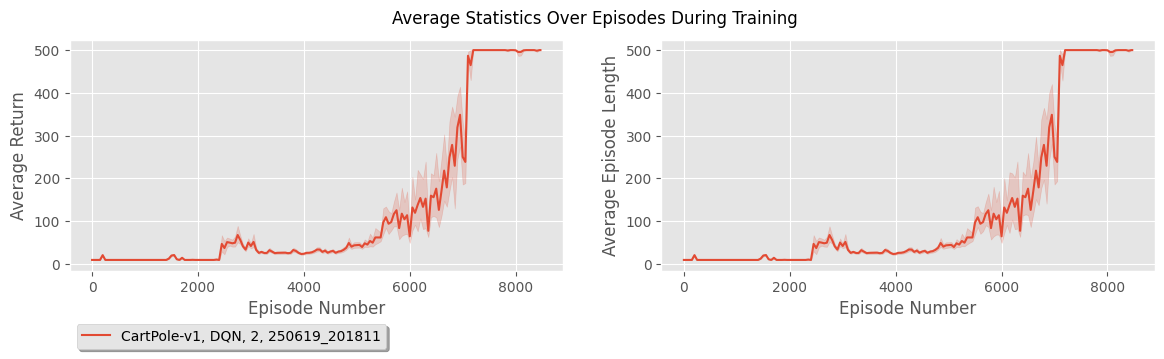

In [20]:
if not _grading_mode: #DO NOT EDIT
    #-------------From here you can edit-------------
    eval_params = edict()  # eval_params - evaluation settings for trained agent

    eval_params.run_name00 = exp.run_name
    eval_params.exp_type00 = exp.exp_type

    agent_labels = []

    episode_axis_limit = None

    hf.plotter_agents_training_stats(eval_params, agent_labels, episode_axis_limit, plot_returns=True, plot_episode_len=True)

## TensorBoard Inline

In [17]:
if not _grading_mode: #DO NOT EDIT
    #-------------From here you can edit-------------
    %load_ext tensorboard
    %tensorboard --logdir logs --host localhost

In [18]:
# Used for grading. Do not change.

In [19]:
# Used for grading. Do not change.

In [20]:
# Used for grading. Do not change.

In [21]:
# Used for grading. Do not change.